# Eigenstrapping Tutorial

This tutorial demonstrates how to use the eigenstrapping framework, developed by [Koussis *et al.* (2025)](https://doi.org/10.1162/IMAG.a.71), to generate null distributions for statistical analysis of associations between brain annotations. 

A null map, $y'(\vec{r})$, is generated according to the following equation:

$$y'(\vec{r})=\sum\limits_{\Lambda=0}^G\sum\limits_{\mu=-\Lambda}^\Lambda\bigg(\beta_{\Lambda\mu}\psi'_{\Lambda\mu}(\vec{r})\bigg)+\epsilon(\vec{r})$$

where:
- $\Lambda$ denotes the eigengroup
- $\mu$ denotes the eigenmode within the eigengroup
- $G$ is the maximum eigengroup
- $\beta_{\Lambda\mu}$ are the coefficients obtained by decomposing the original map onto the eigenmodes
- $\psi'_{\Lambda\mu}(\vec{r})$ are the new eigenmodes from the rotated eigengroup
- $\epsilon(\vec{r})$ is the residual term

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from importlib.resources import files, as_file
from neuromodes import EigenSolver
from neuromodes.io import fetch_surf
from nsbutils.plotting import plot_surf

In [ ]:
# Configuration
density = '32k'
n_modes = 15**2  # First 15 eigengroups
n_nulls = 1000
seed = 365

We start by loading a mesh, initiating the `EigenSolver` class, and computing the eigenmodes.

In [ ]:
mesh, _ = fetch_surf(density=density, hemi='L', surf_type='sphere')
mesh.vertices = mesh.vertices / 100.0  # Scale vertices to unit sphere
v = mesh.vertices

# Synthetic data for testing
map0 = np.sin(mesh.vertices[:, 0]*np.pi) + np.sin(mesh.vertices[:, 1]*2*np.pi) + np.cos(mesh.vertices[:, 2]*3*np.pi)
map1 = np.cos(mesh.vertices[:, 0]*np.pi) + np.cos(mesh.vertices[:, 1]*2*np.pi) + np.cos(mesh.vertices[:, 2]*3*np.pi)

solver = EigenSolver(mesh, mask=None).solve(n_modes)

We can then call the `eigenstrap` class method to generate a null distribution. This may take a few minutes depending on the number of CPU cores available.

In [ ]:
# Calculate nulls
nulls = solver.eigenstrap(
    data=map0,
    n_nulls=n_nulls,
    seed=seed,
    randomize=False,
    resample=None,
    n_jobs=-1   # Use all available CPU cores
)
print(nulls.shape)

(32492, 1000)


Now let's visualize the original map and a few null maps.

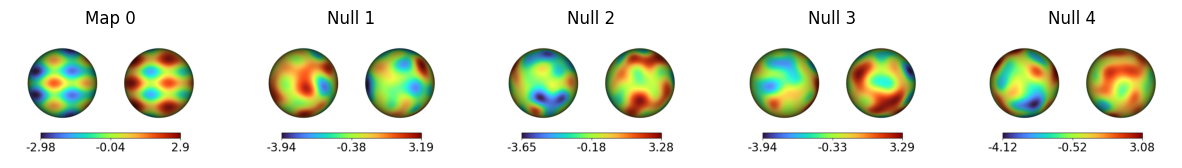

In [ ]:
# Plot nulls
lh_surfpath = files('neuromodes.data') / f'sp-human_tpl-fsLR_den-{density}_hemi-L_sphere.surf.gii'

with as_file(lh_surfpath) as lh_surfpath:
    fig1, axs = plt.subplots(1, 5, figsize=(15, 6))
    axs = axs.ravel()
    for i, ax_i in enumerate(axs):
        if i == 0:
            data = map0
            title = "Map 0"
        else:
            data = nulls[:, i-1]
            title = f"Null {i}"

        color_range = (np.nanpercentile(data, 5), np.nanpercentile(data, 95))

        plot_surf(lh_surfpath, data, cmap='turbo', color_range=color_range, ax=axs[i], cbar=True)
        axs[i].set_title(title)


We can check that the power spectrum distribution between the original and the nulls is exactly preserved on the sphere (it will only be approximately preserved on surfaces where the group relationship is not exact). 

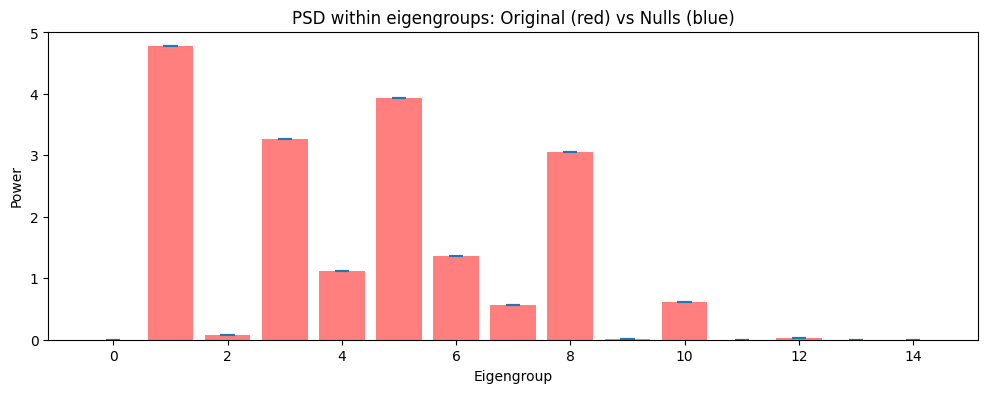

In [ ]:
# PSD within each eigengroup should be preserved
group_indices = np.floor(np.sqrt(np.arange(n_modes))).astype(int)
n_groups = group_indices.max() + 1

beta0 = solver.decompose(map0)
psd0 = np.bincount(group_indices, weights=beta0.ravel()**2)

beta1 = solver.decompose(nulls)
psd1 = np.array([np.bincount(group_indices, weights=beta1[:, i].ravel()**2) for i in range(n_nulls)])


fig, axs = plt.subplots(figsize=(12,4))
axs.bar(range(n_groups), psd0, color='red', alpha=0.5)
axs.violinplot(psd1, positions=range(n_groups))
axs.set_title("PSD within eigengroups: Original (red) vs Nulls (blue)")
axs.set_xlabel("Eigengroup")
axs.set_ylabel("Power")
plt.show()

Let's also plot the distribution of correlation coefficients between the original map and the null maps.

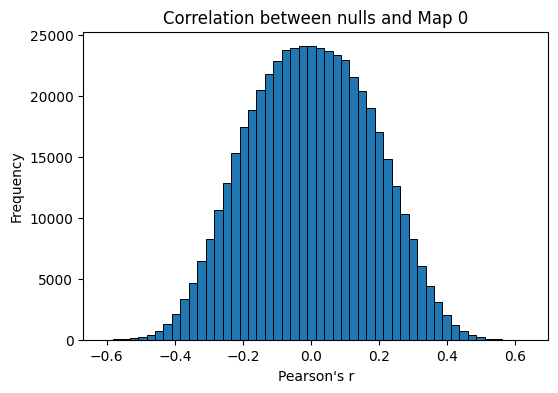

In [ ]:
# Plot null correlation distribution
inter_null_corrs = np.corrcoef(nulls.T)
triu_inds = np.triu_indices_from(inter_null_corrs, k=1)
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(inter_null_corrs[triu_inds], bins=50, edgecolor='black', linewidth=0.7)
ax2.set_title("Correlation between nulls and Map 0")
ax2.set_xlabel("Pearson's r")
ax2.set_ylabel("Frequency")
plt.show()

Now we can use our nulls to test whether the map0 is significantly correlated with another similar looking map.

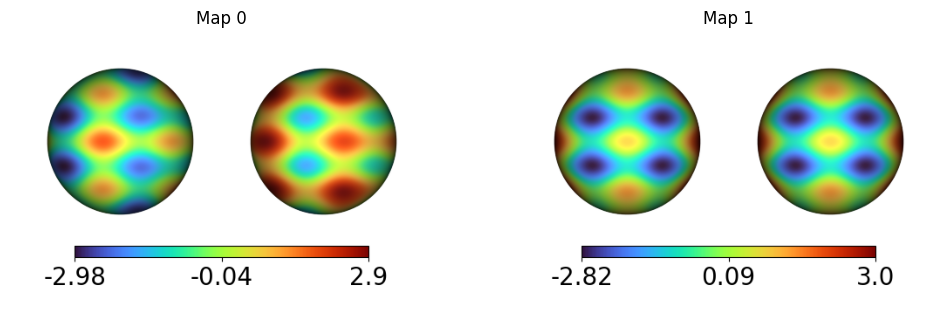

Observed correlation between map0 and map1: 0.2511


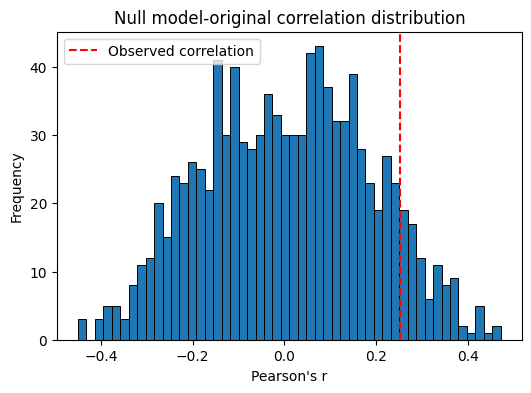

p-value: 0.1758


In [ ]:
# Visualise map0 and map1
fig, ax_i = plt.subplots(1, 2, figsize=(12, 6))
with as_file(lh_surfpath) as lh_surfpath:
    plot_surf(lh_surfpath, map0, cmap='turbo', ax=ax_i[0], cbar=True)
    plot_surf(lh_surfpath, map1, cmap='turbo', ax=ax_i[1], cbar=True)
ax_i[0].set_title("Map 0")
ax_i[1].set_title("Map 1")
plt.show()

# Compute correlation between map0 and map1
corr = np.corrcoef(map0, map1)[0, 1]
print(f"Observed correlation between map0 and map1: {corr:.4f}")

# Compute correlation between map0 and nulls
null_corrs = np.corrcoef(map0, nulls, rowvar=False)[0, 1:]

# Plot correlation distributions
fig, ax_i = plt.subplots(figsize=(6, 4))
ax_i.hist(null_corrs, bins=50, edgecolor='black', linewidth=0.7)
ax_i.axvline(corr, color='red', linestyle='--', label='Observed correlation')
ax_i.set_title("Null model-original correlation distribution")
ax_i.set_xlabel("Pearson's r")
ax_i.set_ylabel("Frequency")
# ax_i.set_xlim(-0.6, 0.6)
ax_i.legend()
plt.show()

pvalue = (np.sum(np.abs(null_corrs) >= np.abs(corr)) + 1) / (n_nulls + 1)
print(f"p-value: {pvalue:.4f}")